# mass ratio dependence

basically, sometimes we thing $P(q)$ is flat, sometimes we think it is a power law. I want to see how much this actually matters

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Generate Synthetic Data

In [25]:
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')

In [46]:
data_52 = sd.create_synthetic_data(object_count=250000, catalogue=mdwarfs[::10], binary_fraction=0.3, period_model=(5,2), mass_model=None, ecc_type='circular')

Computing Binaries:   0%|          | 0/75000 [00:00<?, ?it/s]

In [44]:
data = sd.create_synthetic_data(object_count=250000, catalogue=mdwarfs[::10], binary_fraction=0.3, period_model=(4,1.3), mass_model=None, ecc_type='circular')

Computing Binaries:   0%|          | 0/75000 [00:00<?, ?it/s]

In [45]:
data_exp = sd.create_synthetic_data(object_count=250000, catalogue=mdwarfs[::10], binary_fraction=0.3, period_model=(4,1.3), mass_model="exponential", ecc_type='circular')

Computing Binaries:   0%|          | 0/75000 [00:00<?, ?it/s]

In [68]:
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.3} Binary fraction, {(4,1.3)} T distribution, {0} q index"
outdata["meta"]["notes"] = "2026.01.09 250k samples, circular only, flat in q"
outdata["data"] = data

outfile = open('./massive_data/massive_samples_413.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.3} Binary fraction, {(5,2)} T distribution, {0} q index"
outdata["meta"]["notes"] = "2026.01.09 250k samples, circular only, flat in q"
outdata["data"] = data_52

outfile = open('./massive_data/massive_samples_52.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.3} Binary fraction, {(4,1.3)} T distribution, {0.5} q index"
outdata["meta"]["notes"] = "2026.01.09 250k samples, circular only, exponential q"
outdata["data"] = data_exp

outfile = open('./massive_data/massive_samples_413_qexp.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

In [3]:
data = pickle.load(open("./massive_data/massive_samples_413.pkl", "rb"))["data"]
data_exp = pickle.load(open("./massive_data/massive_samples_413_qexp.pkl", "rb"))["data"]
data_52 = pickle.load(open("./massive_data/massive_samples_52.pkl", "rb"))["data"]

In [70]:
bdata = data[[d["is_binary"] == True for d in data]]
bdata_exp = data_exp[[d["is_binary"] == True for d in data_exp]]

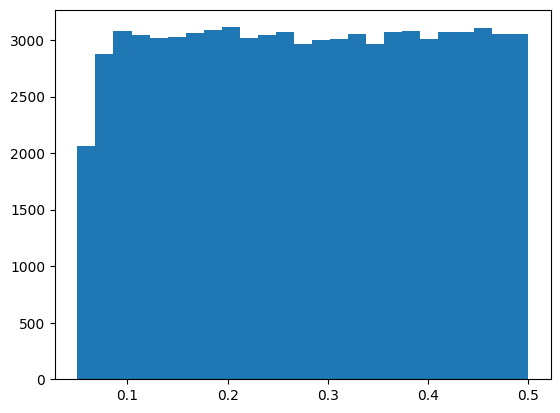

In [71]:
plt.hist([b["q"] for b in bdata], bins=25);

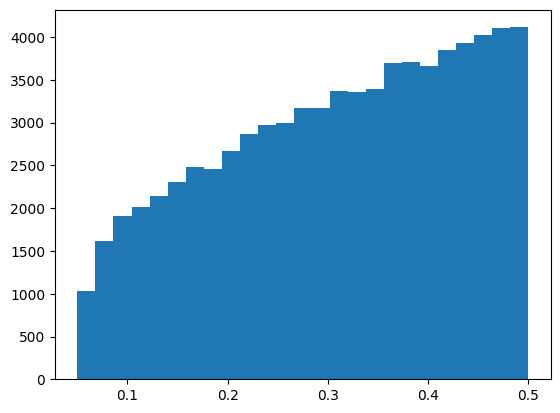

In [49]:
plt.hist([b["q"] for b in bdata_exp], bins=25);

ok so they really are quite different

## Compute Binarities

Here, take the two different datasets and run each of them with the wrong and right mass ratio model

In [3]:
data = pickle.load(open("./massive_data/2026-01-20-flat_q.pkl", "rb"))["data"]
data_exp = pickle.load(open("./massive_data/2026-01-20-reference.pkl", "rb"))["data"]

In [4]:
sc_cubes = pickle.load(open("./data/2026-01-16-mdwarf_mbins_3plx_turnover.pkl", "rb"))

In [ ]:
res = np.zeros((2,2,2,2500))
res_est = np.zeros((2,2,3))

### FLATQ DATA ###
indices = [0,5,7,9,12]
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
masses = np.array([row["mass"] for row in data_const_fb])
percs = np.percentile(masses, np.arange(0, 110, 10))
for row in tqdm(data_const_fb):
    df = dict()
    df["soltype_index"] = indices.index(row["solution_type"])   
    df["mass_index"] = np.minimum(np.digitize(row["mass"], percs) - 1, 9)
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)
working_catalogue = np.array(working_catalogue)

# USE FLATQ MODEL
model_cube = Sampler.create_model_cube((15,15), p_model=(4,1.3))
synthsampler = Sampler.popsampler(sc_cubes, working_catalogue, model_cube=model_cube)
res[0,0] = synthsampler.binarity(resolution=2500, scale=2, mass_binned=True,verbose=True)
#synthsampler.fb_likelihood(fb=0.3)
res_est[0,0] = synthsampler.fb_estimator()

# USE QEXP MODEL
model_cube = Sampler.create_model_cube((15,15), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes, working_catalogue, model_cube=model_cube)
res[0,1] = synthsampler.binarity(resolution=2500, scale=2, verbose=True)
#synthsampler.fb_likelihood(fb=0.3)
res_est[0,1] = synthsampler.fb_estimator()

### QEXP DATA ###
synthdata = data_exp
working_catalogue = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in synthdata[::10]:
    df = dict()
    for item in relevant_list:
        df[item] = float(row[item])
    working_catalogue.append(df)

# USE FLATQ MODEL
model_cube = Sampler.create_model_cube((15,15), p_model=(4,1.3))
synthsampler = Sampler.popsampler(sc_cubes, working_catalogue, model_cube=model_cube)
res[1,0] = synthsampler.binarity(resolution=2500, scale=2, verbose=True)
#synthsampler.fb_likelihood(fb=0.3)
res_est[1,0] = synthsampler.fb_estimator()

# USE QEXP MODEL
model_cube = Sampler.create_model_cube((15,15), p_model=(4,1.3), q_model=0.5)
synthsampler = Sampler.popsampler(sc_cubes, working_catalogue, model_cube=model_cube)
res[1,1] = synthsampler.binarity(resolution=2500, scale=2, verbose=True)
#synthsampler.fb_likelihood(fb=0.3)
res_est[1,1] = synthsampler.fb_estimator()

Reducing catalogue...
Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

Reducing catalogue...
Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

Reducing catalogue...
Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

Reducing catalogue...
Computing grids...


  0%|          | 0/25000 [00:00<?, ?it/s]

Computing likelihoods...


  0%|          | 0/2500 [00:00<?, ?it/s]

In [7]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.12 Compare q-0.5 and q-0 models"
outdata["data"] = dict()
outdata["data"] = [res, res_est]

outfile = open('./plot_data/massratio_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

## Make Plot

In [2]:
import style

In [3]:
res, res_est = pickle.load(open("./plot_data/period_test.pkl", "rb"))["data"]

/tmp/ipykernel_1668891/1633944428.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend();
/tmp/ipykernel_1668891/1633944428.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=legend_label[:-1])


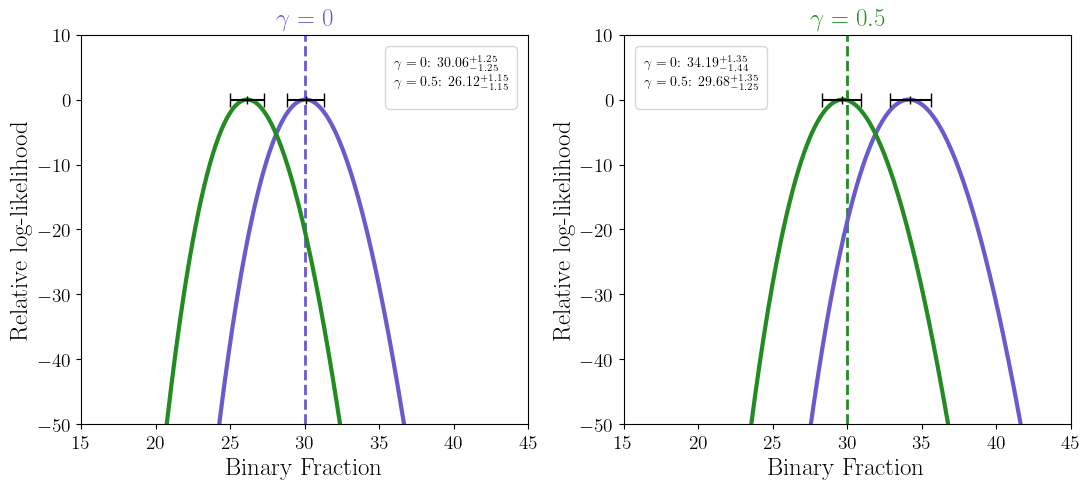

In [4]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
binary_fraction=0.3
cols = ['slateblue', 'forestgreen']
q_models = [0, 0.5]
for i, q_model in enumerate(q_models):
    ax = axs[i]
    ax.axvline(x=100*binary_fraction, c=cols[i], linestyle="--", linewidth=2);#, label=f"TRUTH: {binary_fraction}")
    ax.legend();
    legend_label = ''
    for j in range(2):
        fbs, likelihoods = res[i,j]
        mle, p, m  = res_est[i, j]
        ax.plot(100*fbs, likelihoods-np.max(likelihoods), c=cols[j], linewidth=3);
        legend_label = legend_label + r'$\gamma={}$: ${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$'.format(q_models[j],100*mle,100*p,100*m) + "\n"
        ax.errorbar(100*mle, 0, xerr=([100*p], [100*m]), c="k", marker='|', capsize=5, zorder=2)
        ax.set_xlabel("Binary Fraction");
        ax.set_ylabel("Relative log-likelihood");
        ax.set_title(r'$\gamma={}$'.format(q_model), color=cols[i])
    ax.legend(title=legend_label[:-1])
    ax.set_ylim(top=10, bottom=-50)
    ax.set_xlim([15,45])
plt.tight_layout()
#plt.savefig("./plots/2026-01-12-mass_ratio_test.png", dpi=800)

In [5]:
latex_table_grid = "\\begin{tabular}{lccc}\n\\toprule\nData $\\backslash$ Model & (4, 1.3) & (4, 2) & (5, 2) \\\\\n\\midrule\n"
q_model_labels = [0, 0.5]
for i, q_data in enumerate(q_model_labels):
    row = f"$\\gamma={q_data}$ "
    for j, q_model in enumerate(q_model_labels):
        mle_val = res_est[i, j, 0] * 100
        p_val = res_est[i, j, 1] * 100
        m_val = res_est[i, j, 2] * 100
        row += f"& ${mle_val:.2f}^{{+{p_val:.2f}}}_{{-{m_val:.2f}}}$ "
    row += "\\\\\n"
    latex_table_grid += row
latex_table_grid += "\\bottomrule\n\\end{tabular}"
print(latex_table_grid)

\begin{tabular}{lccc}
\toprule
Data $\backslash$ Model & (4, 1.3) & (4, 2) & (5, 2) \\
\midrule
$\gamma=0$ & $30.06^{+1.25}_{-1.25}$ & $26.12^{+1.15}_{-1.15}$ \\
$\gamma=0.5$ & $34.19^{+1.35}_{-1.44}$ & $29.68^{+1.35}_{-1.25}$ \\
\bottomrule
\end{tabular}


In [14]:
f'{0.303/0.264:.2f}', f'{0.352/0.306:.2f}'

('1.15', '1.15')

In [16]:
a_0 = Sampler.area_in_range_powerlaw((0.05,1), 0)/Sampler.area_in_range_powerlaw((0.05,0.5), 0)
a_05 = Sampler.area_in_range_powerlaw((0.05,1), 0.5)/Sampler.area_in_range_powerlaw((0.05,0.5), 0.5)
q_as = [a_0, a_05]

/tmp/ipykernel_1808058/2473186762.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend();
/tmp/ipykernel_1808058/2473186762.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=legend_label[:-1])


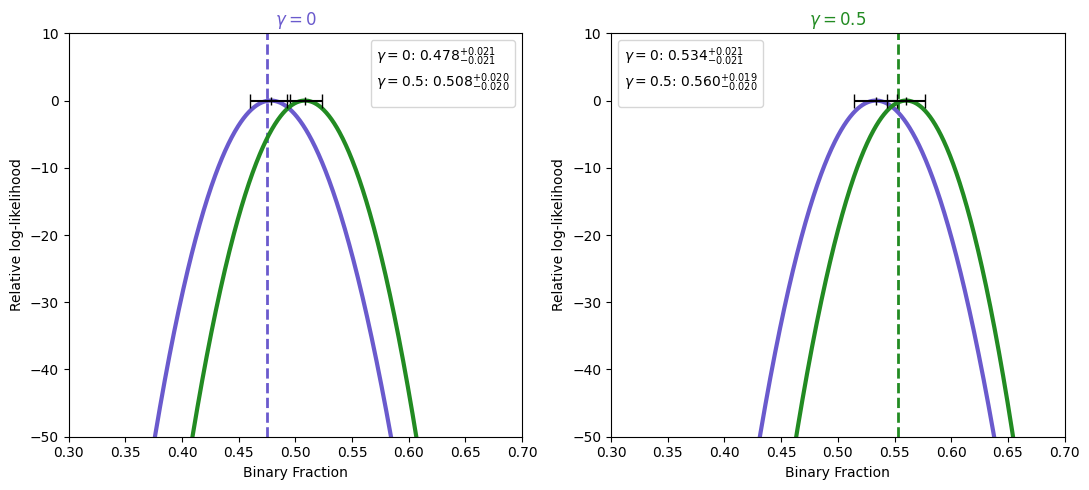

In [22]:
fig, axs = plt.subplots(1,2, figsize=(11,5))
binary_fraction=0.3
cols = ['slateblue', 'forestgreen']
q_models = [0, 0.5]
for i, q_model in enumerate(q_models):
    ax = axs[i]
    ax.axvline(x=Sampler.convert_binarity(binary_fraction, q_as[i]), c=cols[i], linestyle="--", linewidth=2);#, label=f"TRUTH: {binary_fraction}")
    ax.legend();
    legend_label = ''
    for j in range(2):
        fbs, likelihoods = res[i,j]
        mle, p, m  = res_est[i, j]
        adjusted_mle = Sampler.convert_binarity(mle, q_as[j])
        adjusted_p = Sampler.convert_binarity(mle+p, q_as[j]) - adjusted_mle
        adjusted_m = adjusted_mle - Sampler.convert_binarity(mle-m, q_as[j])
        ax.plot(Sampler.convert_binarity(fbs, q_as[j]), likelihoods-np.max(likelihoods), c=cols[j], linewidth=3);
        legend_label = legend_label + r'$\gamma={}$: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(q_models[j],adjusted_mle,adjusted_p,adjusted_m) + "\n"
        ax.errorbar(adjusted_mle, 0, xerr=([p], [m]), c="k", marker='|', capsize=5, zorder=2)
        ax.set_xlabel("Binary Fraction");
        ax.set_ylabel("Relative log-likelihood");
        ax.set_title(r'$\gamma={}$'.format(q_model), color=cols[i])
    ax.legend(title=legend_label[:-1])
    ax.set_ylim(top=10, bottom=-50)
    ax.set_xlim([0.3,0.7])
plt.tight_layout()